Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 2 Classification

## Section 1: Data Preparation

Talk about data prep here.

[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
# read in the data
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)

runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


In [3]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_df.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_df.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_df = runs_df_onehot.reset_index(drop=True)

[5 points] Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

## Section 2: Modeling and Evaluation

Intro paragraph for section 2 here...

[10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

Our primary metric for evaluating model performance is Area Under the Curve (AUC). AUC score provides a good balance between accuracy, specificity, and sensitivity. In an unbalanced data set such as this one, you cannot rely on accuracy alone. 

Since 92% of the observations in the data set are losers, creating a "model" that predicts a loss for every observation would have an accuracy of 92% but offer no practical use.

[10 points] Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

For dividing our test and train data sets we used 10-fold Stratified Cross Validation (CV). In 10-fold CV, the data set is divided into 10 groups where one becomes the hold out (test) set and the other 9 become the training data. In Stratified CV, the proportion of observations is preserved in each fold. There are many more losers than winners in this data set. Therefore, preserving the proportion of winners to losers in each fold is important to ensure you do not accidentally create a test set of all losers.

In [4]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head(10)

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,0,0,0,1,0,0,0,0,0,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,0,0,0,1,0,0,0,0,0,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,0,0,0,1,0,0,0,0,0,0
5,5,0,6,3296,3,0.0,1.25,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,1
6,6,0,7,911,12,0.0,9.50,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
7,7,0,8,2170,1,1.0,0.00,3,AUS,Gelding,...,0,0,0,1,0,0,0,0,0,1
8,8,0,9,1730,13,0.0,9.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
9,9,0,10,2998,14,0.0,999.00,3,AUS,Mare,...,0,0,0,0,0,0,1,0,0,0


In [5]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
runs_data.head()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
#train test split won
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

#train test split place
X_train_place,X_test_place,Y_train_place,Y_test_place = train_test_split(runs_data,runs_target2,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train_place = mmscl_obj.fit_transform(X_train_place,y = None)
X_test_place = mmscl_obj.transform(X_test_place)


### Section 2.1: Model 1 - K-Nearest Neighbors

K-Nearest Neighbors is an algorithm frequently used for classification. In order to classify an observation, the algorithm measures the distance from the given observation to it's K nearest neighbors, where K is a tunable parameter.

For each iteration of the model fitting, we try a different K value and print out the model accuracy and AUC score. Because the data set is not balanced, we use AUC as the primary metric for comparing model performance. If we only used accuracy, we could achieve an accuracy of over 90% simply by classifying every observation as a "los", but this has no practical use.

First, we implemented two models. Both use Euclidean distance but one uses a uniform weight and the other uses distance. For uniform weight, all the nearest neighbors have the same impact in classification. In distance, closer neighbors have more impact.

The difference in model performance for uniform vs. distance was negligable, but the model with weights='distance' trained more quickly so we elected to use that parameter.

#### Euclidean Distance, Uniform Weights

In [ ]:
# Use Euclidean distance and iterate over several K-values
## ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='uniform', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

#### Euclidean Distance, Distance Weights

In [ ]:
# Use Euclidean distance - sqrt(sum((x - y)^2))
## ‘distance’ : weight points by the inverse of their distance. 
##    in this case, closer neighbors of a query point will have a greater 
##    influence than neighbors which are further away.

Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)
    
# Note: weights='distance' runs quicker and produces the same accuracy results

The next parameter we experimented with was the weight metric. We re-ran the model several times using different metrics from the sklearn DistanceMetric library, to include Manhatten and Chebyshev.

Again, the model performance for the different metrics was negligable so we elected to use Euclidean distance since it is well optimized for large data sets.

#### Manhatten Distance

In [ ]:
# Use Manhatten distance - sum(|x - y|)

Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

#### Chebyshev Distance

In [ ]:
# Use ChebyshevDistance distance - max(|x - y|)

Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

With each of the KNN models above, the accuracy and AUC tend to stabilize at around k=11. Note as the K value increases so too does the accuracy but the AUC decreases. Choosing a smaller K-value such as 7 produces a goo balace between the different metrics.

We fit a final KNN using the parameters selected: Euclidean, Distance weights for neighbors, and 7 neighbors.

#### KNN with Euclidean, Distance weight, and K=7 neighbors

In [ ]:
# Based on above, Euclidean with K=7 is a good combination of accuracy and AUC
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

Below is the Confusion Matrix plotted for the model. As can be seen, it classified the majority of observations as loses (correctly). This makes sense since about 92% of the data set are horses who did not win their race.

#### Confusion Matrix for KNN Model

In [ ]:
plot_confusion_matrix(clf_knn, X_test, Y_test)

In [ ]:
# I tried several different algorithm parameters here (e.g. kd_tree, ball_tree) without effect
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean', algorithm='kd_tree')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Accuracy of classifier with %d neighbors is: %.3f'%(x,acc), ' AUC: %.3f'%auc)

From the Confusion Matrix above, notice the large number of false positives. The model incorrectly classified over 1000 observations as wins when they should have been loses. It only correctly classified about 50 wins. Since this data set is results of horse races, you can assume an interested party would be a gambler. The KNN model would not be of much benefit to a gambler due to the large number of Type I error in proportion to true positive results.

### Section 2.2: Model 2 - Random Forest

#### Task 1
The first parameter we want to look at is the performance of forest size to find an optimal number of trees based on the initial data. Determining the correct size of the forest can help keep us from overfitting the model or by wasting resources with building an unneccessarily large forest.

In [ ]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedKFold(n_splits = 10, shuffle = True ,random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

Looking at this information we are aiming for the best precision in our models as we want the best possible number of positive results while limiting false positives. So from this we would look at building a forest with 64 trees. This is also nice because it is the least time consuming. Next we will use this to run a loop to fine the optimal max_depth. This is the metric that determines the overall size of each individual tree by limiting the number of levels it can break down the data into. We will be looking at four levels in this loop, 5,20,100, and no limit(none)

In [ ]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

After assessing these results we wanted to take a look at feature importance on the selected model above. The reason for this is we want to try to eliminate noise variables. This has a secondary side effect with random forests of letting them run faster since the number of features is reduces. There were two ways we went about doing this for random forest. The first was a manual look at the feature importance, and selecting what we deemed to be the most important. The second way was to use recursive feature elimination with cross-validation to look at removing variables. 

In [ ]:
#run best model with normal train test split for feature selection
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target):
    # note that these are sparse matrices
    X_train, X_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    Y_train, Y_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

clf_rf = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rf.fit(X_train,Y_train.values.ravel())
yhat = clf_rf.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)

In [ ]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_rf, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

Just by looking at this graph we can make some simple eliminations of features that did not help in this model. Likely we would want to keep the first three factors and the last 15 factors in the model and eliminate the rest. This has been done in the data below.

In [ ]:
optfeatures = featureorder[:3]
optfeatures2 = featureorder[-15:]
optfeatures = optfeatures + optfeatures2
dataopt = runs_data[optfeatures]

In [ ]:
#Recursive Feature Elimination
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf, step=1, cv=StratifiedKFold(2),
              scoring='precision',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (precision)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

In [ ]:
#dropping features from dataset not selected by recursive feature elimination
dataopt2 = runs_data.drop(runs_data.columns[[10,15,21,26,28,32]],axis = 1)

After building out these new datasets we decided to run the same crossvalidated pieces against them. You can see the results of these below. The first two loops are run on the manually optimized data.

In [ ]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

With the set of manually optimized data we see that 75 trees has the greatest precision. We are also seeing increased scores for AUC and Precision. There is a jump here from .7794 to .782 and .1734 to .1751 respectively. The model, however, does take slightly longer to run with the larger forest size, but not substantially longer.

In [ ]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 75, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

Looking at the results from max_depth, we would want to select a depth max of 100 like in the last model. This is because the difference between precision and AUC is none existant between limiting depth to 100 and no limit. So the runtime benefit here is the deciding factor. Next we will run this again but with the recursive feature elimination dataset to see if there is a difference between the two.

In [ ]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

Just based on this first run. It doesnt look like the recursive feature elimination will beat out the manual feature selection but for the sake of being thorough we went ahead and ran the loop to look at depth with a forest size of 128 trees.

In [ ]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 75, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

The results of this loop were surprising as originally it looked as though the RFE dataset would be coming back with lower stats than the manually selected features. However, once the loop for max depth was run there was a jump in statistics from precision .4219 and AUC .7477 to precision .4277 and AUC .7491 at a max depth of 100. This means that our best model for runtime efficiency, precision and AUC would be a Random Forest with weight classed balance, a max depth of 100 and forest size of 75.

#### Task 2
Now that we have a best model for the wins of task one we need to move to task two of trying to classify horses that place instead of just the winners from each race. In theory the statistics for these models should all be better due to the fact that the number of posible successes is higher proportionally.

In [ ]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

In this first run of the data running a with no max depth interestingly seems to be comparable statistics wise with running a model with max depth 100, and strangly it ran faster than the max depth 100. So we will now run the loop again to tune forest size using this max depth.

In [ ]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = None, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

After running the second loop our best metrics can be found with a forest size of 128 trees. Now that we have these base statistics. We will want to again optimize the data set using RFE. We decided not to attempt to beat the machine this time and instead utilize RFE to expidite model build.

In [ ]:
#run best model with normal train test split for feature selection
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target2):
    # note that these are sparse matrices
    X_train, X_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    Y_train, Y_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

clf_rf = RandomForestClassifier(max_depth = None, n_estimators = 128, random_state = 0, class_weight = 'balanced')
clf_rf.fit(X_train,Y_train.values.ravel())
yhat = clf_rf.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)

In [ ]:
#Recursive Feature Elimination
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf, step=1, cv=StratifiedKFold(2),
              scoring='precision',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (precision)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

In [ ]:
#dropping features from dataset not selected by recursive feature elimination
dataopt3 = runs_data.drop(runs_data.columns[[8,10,11,14,15,17,18,20,21,23,25,26,28,30,31,32]],axis = 1)


With this data set because the number of possible successes goes up, it is not surprising that a smaller number of features is needed to predict this success. We see all the same features eliminated that were eliminated when predicting a winner, but more are added to the list as they are less important in predicting a top 3 placing. Now that we have the optimized dataset for place. We will run the loops again to look for improved performace of both metrics and speed.

In [ ]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

It is interesting looking at this data where the depth 5 statistics beat the original non-optimized model, however as depth increased. The optimized model didnt seem to keep pace with the original model.  This might be a similar situation to the last attempt at optimization though where the final model did manage to beat out the original model. From this we will use max depth None to try to optimize our final model. The reason for chosing None of 100 even though 100 had a better calculation speed was to try to compare like for like models here. 

In [ ]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = None, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

The final optimized model would have been with a max_depth of None and a forest size of x. Interestingly the optimized model here did not perform better than the full model. This could be because the algorithm for it is trying to balance bias and variability and this time the metrics just didn't increase the precision, but may have made it more adaptable to another data set. However, just based on metrics alone, the full model should be deployed in this case. To compare these to the other types of models we are going to use AUC as it is an easy statistical measure of the predictive power of each model. 

### Section 2.3: Model 3 - Support Vector Machines

Implement model here, including accuracy, AUC score, and Confusion Matrix.

### Section 2.4: Model 4 - Naive Bayes

Implement model here, including accuracy, AUC score, and Confusion Matrix.

The first type of Naive Bayes we would like to run is the Gaussian Naive Bayes. 

In [9]:
var = [.25,.5,1,2,3,4,5,6,7,8,9,10,15,20]
for x in var:
    clf_gnb = GaussianNB(var_smoothing = x)
    clf_gnb.fit(X_train,Y_train.values.ravel())
    yhat = clf_gnb.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('VAR:',x,'AUC:',auc,'ACC:',acc)
    


VAR: 0.25 AUC: 0.5 ACC: 0.9207428391564368
VAR: 0.5 AUC: 0.5 ACC: 0.9207428391564368
VAR: 1 AUC: 0.5 ACC: 0.9207428391564368
VAR: 2 AUC: 0.5 ACC: 0.9207428391564368
VAR: 3 AUC: 0.5 ACC: 0.9207428391564368
VAR: 4 AUC: 0.5 ACC: 0.9207428391564368
VAR: 5 AUC: 0.5 ACC: 0.9207428391564368
VAR: 6 AUC: 0.5 ACC: 0.9207428391564368
VAR: 7 AUC: 0.5 ACC: 0.9207428391564368
VAR: 8 AUC: 0.5 ACC: 0.9207428391564368
VAR: 9 AUC: 0.5 ACC: 0.9207428391564368
VAR: 10 AUC: 0.5 ACC: 0.9207428391564368
VAR: 15 AUC: 0.5 ACC: 0.9207428391564368
VAR: 20 AUC: 0.5 ACC: 0.9207428391564368


Var smoothing at 1 provided the best result below is out test model.

VAR:1 AUC: 0.5 ACC: 0.9207428391564368


C:\Users\nedei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


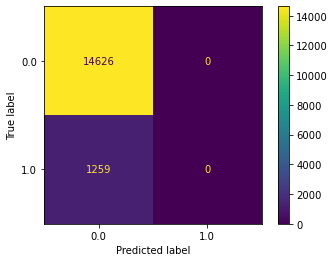

In [10]:
clf_gnb = GaussianNB(var_smoothing = 1)
clf_gnb.fit(X_train,Y_train.values.ravel())
yhat = clf_gnb.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('VAR:1 AUC:',auc,'ACC:',acc)
plot_confusion_matrix(clf_gnb,X_test,Y_test)

Next we will want to look at the feature importance of the model to see if there are any features that could be left out to try to remove noise from the model

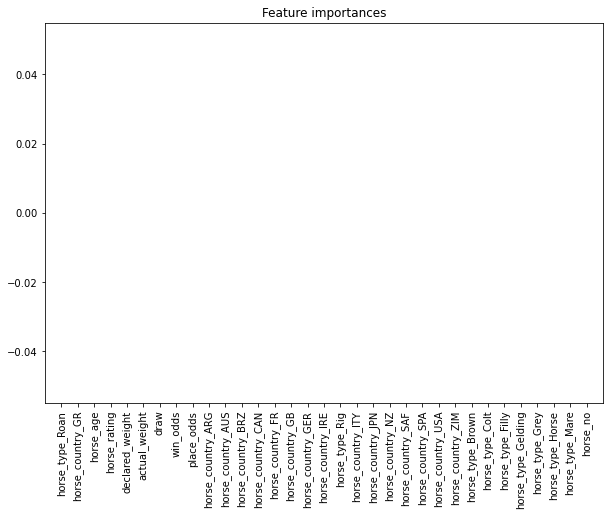

In [11]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_gnb, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

The next model we want to look at is a Complement Naive Bayes. Due to how Complement Naive Bayes works, it has to be scaled differently as it cannot handle negative values.

In [12]:
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target):
    # note that these are sparse matrices
    cnbX_train, cnbX_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    cnbY_train, cnbY_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

mmscl_obj = MinMaxScaler()
cnbX_train = mmscl_obj.fit_transform(cnbX_train,y = None)
cnbX_test = mmscl_obj.fit_transform(cnbX_test,y = None)

for x in var:
    clf_cnb = ComplementNB(alpha = x)
    clf_cnb.fit(cnbX_train,cnbY_train.values.ravel())
    yhat = clf_cnb.predict(cnbX_test)
    acc = mt.accuracy_score(cnbY_test,yhat)
    auc = roc_auc_score(cnbY_test,yhat)
    print('Alpha:',x,'AUC:',auc,'ACC:',acc)

Alpha: 0.25 AUC: 0.6869380972486375 ACC: 0.561347182876928
Alpha: 0.5 AUC: 0.6855026346403887 ACC: 0.561347182876928
Alpha: 1 AUC: 0.6866309592518423 ACC: 0.5621026125275417
Alpha: 2 AUC: 0.6878285230648854 ACC: 0.5643059490084986
Alpha: 3 AUC: 0.6893507364210467 ACC: 0.566446333018571
Alpha: 4 AUC: 0.6910440303219285 ACC: 0.5689014793830658
Alpha: 5 AUC: 0.6917283525008102 ACC: 0.5701605288007554
Alpha: 6 AUC: 0.6936444546016793 ACC: 0.5736858671702865
Alpha: 7 AUC: 0.6945173688716044 ACC: 0.5759521561221278
Alpha: 8 AUC: 0.6950314174894672 ACC: 0.5782184450739691
Alpha: 9 AUC: 0.69554546610733 ACC: 0.5804847340258105
Alpha: 10 AUC: 0.6952391350942363 ACC: 0.5825621655649984
Alpha: 15 AUC: 0.7010933176584819 ACC: 0.5986150456405414
Alpha: 20 AUC: 0.7020610525133346 ACC: 0.6162417374881964


In [ ]:
clf_cnb = ComplementNB(alpha = 20)
clf_cnb.fit(cnbX_train,cnbY_train.values.ravel())
yhat = clf_cnb.predict(cnbX_test)
acc = mt.accuracy_score(cnbY_test,yhat)
auc = roc_auc_score(cnbY_test,yhat)
print('Alpha:20 AUC:',auc,'ACC:',acc)
plot_confusion_matrix(clf_cnb,cnbX_test,cnbY_test)

In [ ]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_cnb, cnbX_test, cnbY_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(cnbX_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(cnbX_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(cnbX_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, cnbX_test.shape[1]])
plt.show()

The final type we would like to try is Bernoulli Naive Bayes

In [ ]:
for x in var:
    clf_bnb = BernoulliNB(alpha = x)
    clf_bnb.fit(X_train,Y_train.values.ravel())
    yhat = clf_bnb.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Alpha:',x,'AUC:',auc,'ACC:',acc)

In [ ]:
clf_bnb = BernoulliNB(alpha = 1)
clf_bnb.fit(X_train,Y_train.values.ravel())
yhat = clf_bnb.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Alpha:',x,'AUC:',auc,'ACC:',acc)
plot_confusion_matrix(clf_bnb,X_test,Y_test)

In [13]:
pip install mlxtend

### Section 2.5: Model Comparison and Feature Importance

[10 points] Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.

[10 points] Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Section 3: Deployment

[5 points] How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Section 4: Summary

Summarize the Lab here.